#### Methods: What is SVM(Support Vector Machine)? How it works?

As a Data Science graduate student and a machine learning enthusiast, SVM is a helpful method in machine learning. For example, if I just have a bunch of data that needs to be solved by SVM method, either Matlab's SVM toolbox, or SciKitLearn in python can provide a convenient and quick solution.

But if we want to understand SVM, we will begin with "KKT...", "Lagrangian ...", "Maximum interval" and so on, these terms tend to follow a whole bunch of heavenly formulas, making us feel dizzy for a while. Not to mention how to connect from one formula to another to understand SVM.

During training process, the SVM learns the importance of each data point for representing the decision boundary between two categories. Usually only those points that lie on the boundary between the categories are important for defining the decision boundary. These points are called support vectors. If we want to make a prediction for a new sample point, we need to measure the distance between this point and each support vector. The classification decision is made based on its distance from the support vector and the importance of the support vector learned during the training process.

Generally speaking, SVM is a method that can divide the samples into two categories！


##### Now Using Twitter Data as: 


I will use Twitter Data, which has 1000+ rows of Text data with Label "0" and "1". Label column has 0 for a positive attitude and 1 for a negative attitude. I will use two columns named "final_tweets" and "label" for SVM classification.

*Step 1 -Library packages*

Library packages for preparing. I will use nltk package for text data cleaning and sklearn package for svm classification.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

*Step 2 - Set random seed*

Set random seed to keep the same result.

In [2]:
np.random.seed(1234)

*Step 3 -Import text data*

Importing text data using relative file paths, then only use "final_twitter" and "label" column for classfication. Then I take the first 5 rows of data to see if the criteria are met.


In [3]:
#| label: tbl-planets
#| tbl-cap: first 5 row of twitter data
txt_data = pd.read_csv("../../data/01-modified-data/cleaned_twitter.csv")
data=txt_data.iloc[:,[-2,-1]]
data.head()

final_tweets  label
0  TxCompleted I think Id lying I put anything ca...      0
1  satoshinftclub WHITELIST amp ETH GIVEAWAYx Whi...      0
2  wl Notice Minting eleveneth cryptobrighton Avn...      0
3  MoonlitMonkey THOmaximalist THOChain You eth Y...      0
4        Did know On average BTC million mined daily      1

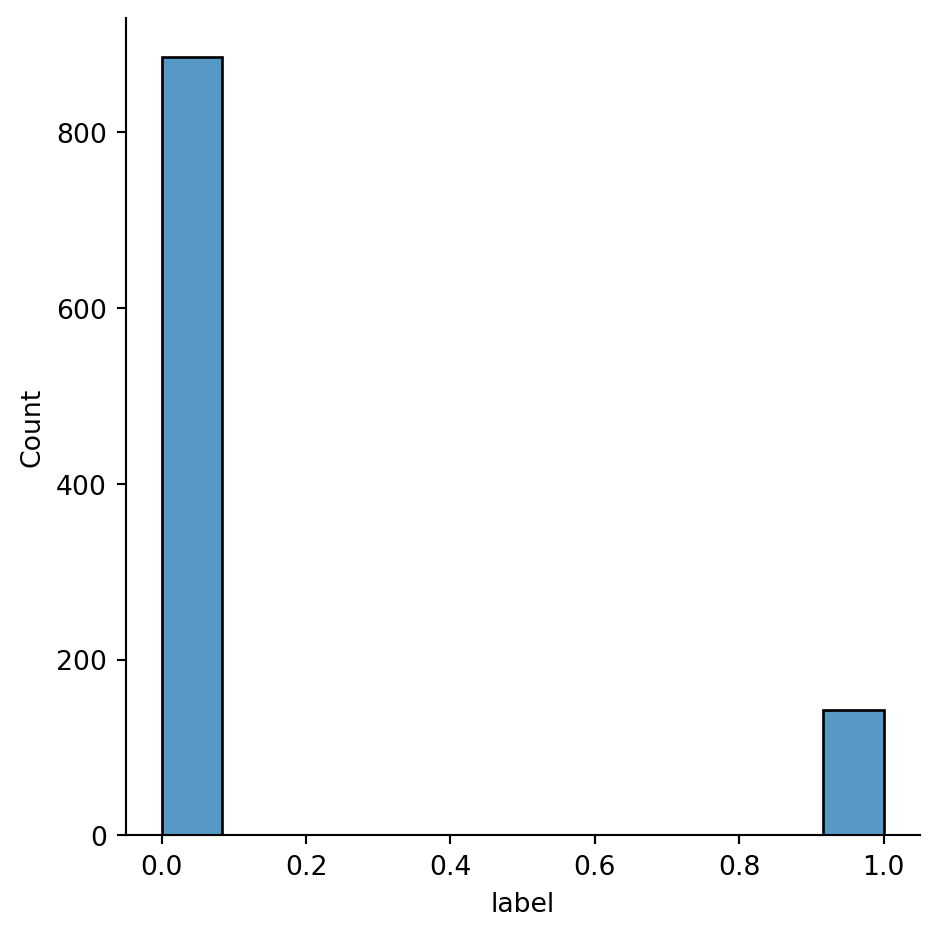

In [4]:
#| label: fig-polar
#| fig-cap: Lable Distribution
sns.displot(data['label'])
plt.show()

*Normalized data*

I had cleaned the data before, but when I looked at the data, I still need to change all the text to lower case. This is required as python interprets 'cat' and 'CAT' differently. And Tokenization: In this each entry in the data will be broken into set of words, which is more conducive to subsequent analysis, Remove Stop words and WordNetLemmatizer. the final cleaned data.


In [5]:
#| label: tbl-planets1
#| tbl-cap: first 5 row of twitter final cleaned data
data['final_tweets'].dropna(inplace=True)
data.final_tweets.str.lower()
data['final_tweets'] =data['final_tweets'].astype(str)
data['final_tweets']= [word_tokenize(entry) for entry in data['final_tweets']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(data['final_tweets']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    data.loc[index,'text_final'] = str(Final_words)

data.head(5)

final_tweets  label  \
0  [TxCompleted, I, think, Id, lying, I, put, any...      0   
1  [satoshinftclub, WHITELIST, amp, ETH, GIVEAWAY...      0   
2  [wl, Notice, Minting, eleveneth, cryptobrighto...      0   
3  [MoonlitMonkey, THOmaximalist, THOChain, You, ...      0   
4  [Did, know, On, average, BTC, million, mined, ...      1   

                                          text_final  
0  ['TxCompleted', 'I', 'think', 'Id', 'lie', 'I'...  
1  ['satoshinftclub', 'WHITELIST', 'amp', 'ETH', ...  
2  ['wl', 'Notice', 'Minting', 'eleveneth', 'cryp...  
3  ['MoonlitMonkey', 'THOmaximalist', 'THOChain',...  
4  ['Did', 'know', 'On', 'average', 'BTC', 'milli...

*Step 5 - Split Train data and Text data*

Twitter data will be split into two datasets, train data and test data. The train data will be used to fit the model and the test dataset will be used to predict. I will use train_test_split function in the sklearn library. I set the parameter test_size=0.2, which means that the training data will have 80% of the corpus and the test data will have the remaining 20%.


In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data['text_final'],data['label'],test_size=0.2,random_state=42)

#### Baseline Model for Comparison & Feature Selection
Random Classifer to prdict y_test:

In [7]:
import random
def generate_label_data(class_labels, weights,N=10000):
    y=random.choices(class_labels, weights = weights, k = N)
    return y

In [8]:
all_len=len(y_test)
len_0=len(y_test[y_test==0])
len_1=len(y_test[y_test==1])
pro_label_y_0=len_0/all_len
pro_label_y_1=len_1/all_len
y=generate_label_data([0,1],[pro_label_y_0,pro_label_y_1],all_len)
y_pred = y
y_true = y_test

The accuracy after running the random classifier is 0.75.  

Display the classification report for test data to random classifer.

In [9]:
#| label: tbl-planets9
#| tbl-cap: the classification report for test data-random classifer
class_report_test_random=classification_report(y_true,y_pred, output_dict=True)
class_report_test_random=pd.DataFrame(class_report_test_random).transpose()
class_report_test_random

precision    recall  f1-score     support
0              0.850000  0.874286  0.861972  175.000000
1              0.153846  0.129032  0.140351   31.000000
accuracy       0.762136  0.762136  0.762136    0.762136
macro avg      0.501923  0.501659  0.501161  206.000000
weighted avg   0.745239  0.762136  0.753378  206.000000

#### Feature Selection & Model Tuning

I transformed the text data into vectors that the model can understand, by using the TF-IDF approach.
The following code can be used to first fit the TG-IDF model across the data. This will help TF-IDF build a vocabulary that it learns from the data and will assign a unique integer to each word. I set the parameter max_features=5000, which means the vocabulary will have a maximum of 5000 unique words/features. I converted X_train，X_test to vectors X_train_Tfidf and X_test_Tfidf. After the transformation, the dataset can be fed into the SVM classification algorithm.


In [10]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['text_final'])
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

Set a function to calculate ACCURACY, Recall and precision score.

In [11]:
def confusion_plot(y_data,y_pred):
    
    print("ACCURACY:", accuracy_score(y_data,y_pred))
    print("NEGATIVE RECALL (Y=0):",recall_score(y_data,y_pred,pos_label=0))
    print("NEGATIVE PRECISION (Y=0):",precision_score(y_data,y_pred,pos_label=0))
    print("POSITIVE RECALL (Y=1):",recall_score(y_data,y_pred,pos_label=1))
    print("POSITIVE PRECISION (Y=1):",precision_score(y_data,y_pred,pos_label=1))

#### Final Results

SVM with Linear kernels: The linear kernel, which produces linear classification bounds, is generally the most computationally efficient and requires the least data. linear function. Fit the classifier on the training data and predict on the test data. Set the classifier to be linear and C equal to 0.5.


In [12]:
C = 0.5 
model_linear = SVC(kernel="linear",C=0.5)
model_linear.fit(X_train_Tfidf, y_train)

yp_test = model_linear.predict(X_test_Tfidf)
print("SVM TEST DATA SUMMARY-Linear Kernels")
confusion_plot(yp_test, y_test)

SVM TEST DATA SUMMARY-Linear Kernels
ACCURACY: 0.9271844660194175
NEGATIVE RECALL (Y=0): 0.9210526315789473
NEGATIVE PRECISION (Y=0): 1.0
POSITIVE RECALL (Y=1): 1.0
POSITIVE PRECISION (Y=1): 0.5161290322580645


Display the classification report for test data.


In [13]:
#| label: tbl-planets2
#| tbl-cap: the classification report for test data(linear)
class_report_test=classification_report(y_test,yp_test, output_dict=True)
class_report_test=pd.DataFrame(class_report_test).transpose()
class_report_test

precision    recall  f1-score     support
0              0.921053  1.000000  0.958904  175.000000
1              1.000000  0.516129  0.680851   31.000000
accuracy       0.927184  0.927184  0.927184    0.927184
macro avg      0.960526  0.758065  0.819878  206.000000
weighted avg   0.932933  0.927184  0.917061  206.000000

Display Confusion Matrix for the test data.


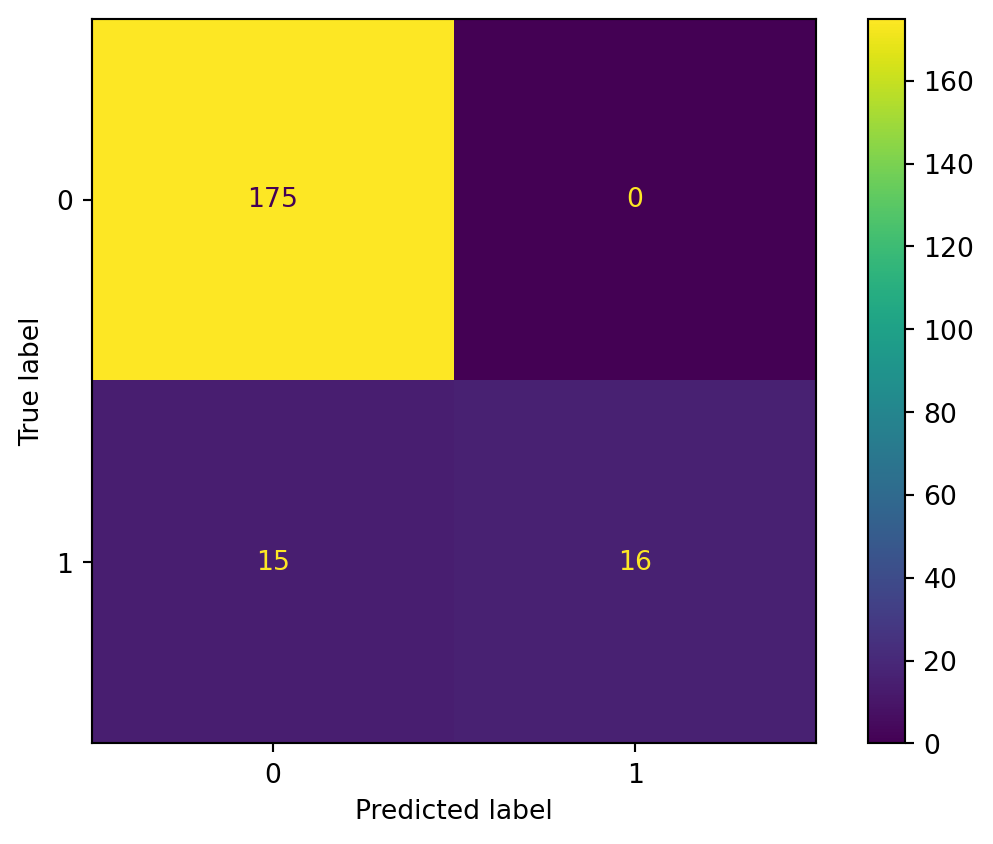

In [14]:
#| label: fig-polar1
#| fig-cap: confusion matrix for test data(linear)

cm_test=confusion_matrix(y_test,yp_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test,display_labels=model_linear.classes_)
disp_test.plot()
plt.show()

From the classification report for test data and the consusion matrix, the accuracy of this SVM model with linear kernal is 0.927184, which is very high.

Although SVM usually performs well, it is very sensitive to parameter settings and data scaling. If you want to improve the model accuracy, I try rbf kenel, radial basis function, also known as Gaussian kernel, which is based on the distance to each support vector to determine the classification boundary, it can map to infinite dimensions and is the most flexible method, but also requires the most data. It is prone to overfitting problems. Exponential function. The smaller the C value, the stronger the regularization effect. The more trained the model is more generalized, but also more likely to be under-fitted. Hence, I choose the value of c is 1000.


In [15]:
model_rbf = SVC(kernel="rbf",C=1000)
model_rbf.fit(X_train_Tfidf, y_train)

yp_test_rbf = model_rbf.predict(X_test_Tfidf)
print("SVM TEST DATA SUMMARY -RBF Kernels")
confusion_plot(yp_test_rbf, y_test)

SVM TEST DATA SUMMARY -RBF Kernels
ACCURACY: 0.9320388349514563
NEGATIVE RECALL (Y=0): 0.9259259259259259
NEGATIVE PRECISION (Y=0): 1.0
POSITIVE RECALL (Y=1): 1.0
POSITIVE PRECISION (Y=1): 0.5483870967741935


Display the classification report for test data.


In [16]:
#| label: tbl-planets3
#| tbl-cap: the classification report for test data(rbf)
class_report_test_rbf=classification_report(y_test,yp_test_rbf, output_dict=True)
class_report_test_rbf=pd.DataFrame(class_report_test_rbf).transpose()
class_report_test_rbf

precision    recall  f1-score     support
0              0.925926  1.000000  0.961538  175.000000
1              1.000000  0.548387  0.708333   31.000000
accuracy       0.932039  0.932039  0.932039    0.932039
macro avg      0.962963  0.774194  0.834936  206.000000
weighted avg   0.937073  0.932039  0.923435  206.000000

Display Confusion Matrix for the test data.


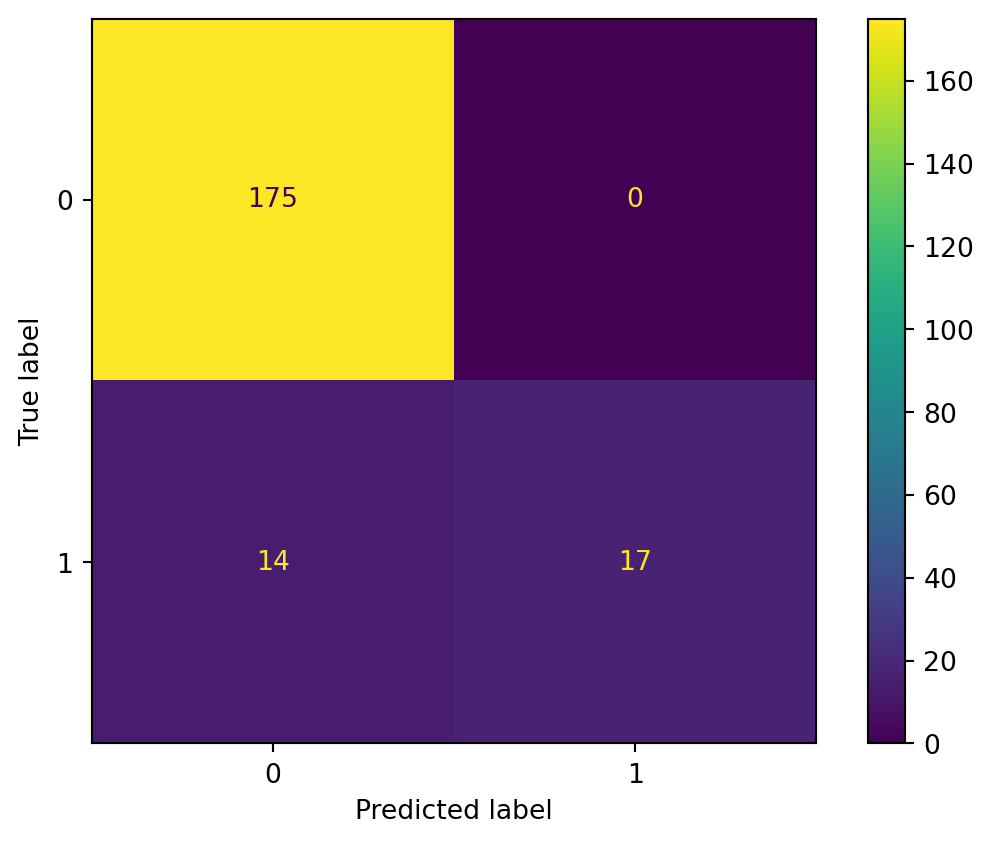

In [17]:
#| label: fig-polar2
#| fig-cap: confusion matrix for test data(rbf)
cm_test_rbf=confusion_matrix(y_test,yp_test_rbf)
disp_test_rbf = ConfusionMatrixDisplay(confusion_matrix=cm_test_rbf,display_labels=model_linear.classes_)
disp_test_rbf.plot()
plt.show()

From the classification report for test data and the consusion matrix, the accuracy of this SVM model with rbf kernal is 0.932039, which is slightly higher than the result from the linear model.


#### Conclusion

From the above SVM model, we can see that the model is very effective in predicting sentiment analysis. After collecting a certain amount of data, the SVM model is more accurate than the NB model but is relatively time-consuming. 

SVM is a very powerful model and performs well on a variety of datasets. SVM allows decision bounds to be complex, even if the data has only a few features. It performs well on data with few features and many features, but does not perform well for scaling the number of samples. Running SVM on data with up to 10,000 samples may perform well, but if the amount of data reaches 1,000,000 rows or even larger, there may be challenges in terms of runtime and memory usage. another disadvantage of SVM is that pre-processing the data and tuning the parameters requires great care. For example, random forests require little or no preprocessing.

###### Pro and Cons

Advantages: good adaptation to high-dimensional spaces; good performance even when the number of data dimensions is larger than the number of samples; only a subset of the training set is required.

Disadvantages: SVM performs poorly if the number of features of the data is much larger than the number of samples; SVM does not directly provide quantitative likelihood predictions, these are usually achieved through cross-validation methods.